# RNN을 이용하여 MNIST Classification 학습하기 
  

MNIST Image를 한 line씩 RNN에 입력하여 classification을 하는 실습을 해보겠습니다.

In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

2.0.0-beta1
2.2.4-tf


In [2]:
if tf.__version__ < '2.0.0':
    tf.enable_eager_execution()

## Hyper Parameters

In [3]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100
n_class = 10

## MNIST/Fashion MNIST Data

In [4]:
## MNIST Dataset #########################################################
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Datasets

In [5]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()  

In [6]:
n_train = train_images.shape[0]
n_test = test_images.shape[0]
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


In [7]:
# pixel값을 0~1사이 범위로 조정
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

# label을 onehot-encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    

# Dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

## Model Function

In [8]:
def create_model():
    model = keras.Sequential()
    model.add(layers.LSTM(units=128, input_shape=(28,28)))
    model.add(layers.Dense(units=10, activation='softmax'))
    return model

In [9]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               80384     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 81,674
Trainable params: 81,674
Non-trainable params: 0
_________________________________________________________________


## Loss Function

In [10]:
@tf.function
def loss_fn(model, images, labels):
    predictions = model(images, training=True)
    loss = tf.reduce_mean(keras.losses.categorical_crossentropy(labels, predictions))   
    return loss

## Calculating Gradient & Updating Weights

In [11]:
@tf.function
def train(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

## Caculating Model's Accuracy

In [12]:
@tf.function
def evaluate(model, images, labels):
    predictions = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
    return accuracy

## Optimizer

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

## Training

In [14]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        train(model,images, labels)
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))


print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.43170071 train accuracy =  0.8624 test accuracy =  0.9466
Epoch: 2 loss = 0.12147664 train accuracy =  0.9643 test accuracy =  0.9660
Epoch: 3 loss = 0.08159260 train accuracy =  0.9764 test accuracy =  0.9727
Epoch: 4 loss = 0.06034389 train accuracy =  0.9824 test accuracy =  0.9773
Epoch: 5 loss = 0.04748048 train accuracy =  0.9866 test accuracy =  0.9802
Epoch: 6 loss = 0.03833858 train accuracy =  0.9894 test accuracy =  0.9816
Epoch: 7 loss = 0.03338304 train accuracy =  0.9910 test accuracy =  0.9835
Epoch: 8 loss = 0.02748258 train accuracy =  0.9927 test accuracy =  0.9833
Epoch: 9 loss = 0.02213941 train accuracy =  0.9942 test accuracy =  0.9822
Epoch: 10 loss = 0.01951719 train accuracy =  0.9953 test accuracy =  0.9846
Epoch: 11 loss = 0.01717429 train accuracy =  0.9957 test accuracy =  0.9835
Epoch: 12 loss = 0.01550313 train accuracy =  0.9958 test accuracy =  0.9846
Epoch: 13 loss = 0.01357005 train accuracy =  0.

## Result Visualization

In [15]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img,cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(n_class), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(n_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

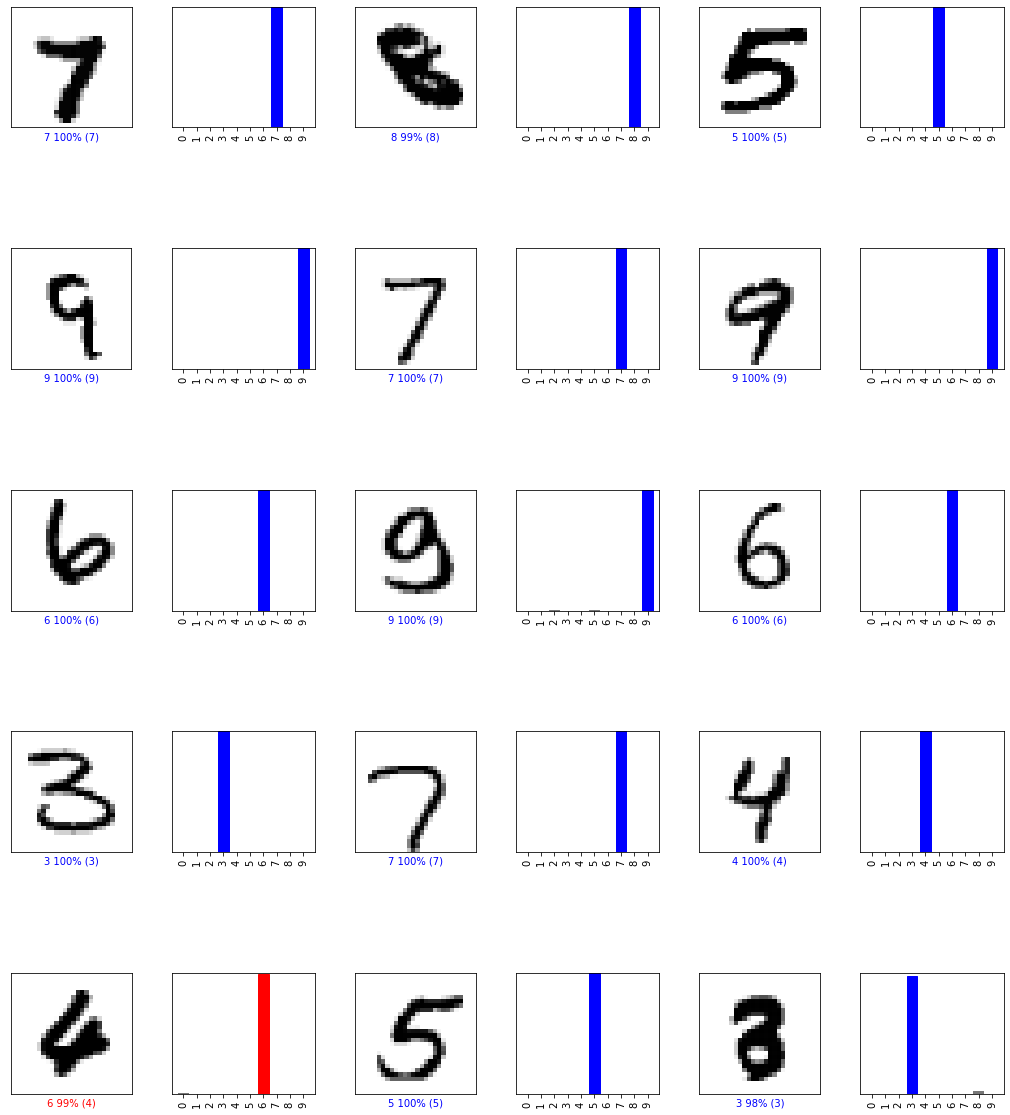

In [16]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break

# Using Keras Only

In [17]:
# Dataset 구성
train_dataset = train_dataset.repeat()

In [18]:
model_k = create_model()
model_k.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               80384     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 81,674
Trainable params: 81,674
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_k.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model_k.fit(train_dataset, epochs=training_epochs,
                    steps_per_epoch=n_train//batch_size,
                    validation_data=test_dataset,
                    validation_steps=n_test//batch_size)

Epoch 1/15

W0824 01:05:44.408193  9136 deprecation.py:323] From C:\Users\jwlee\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



600/600 [==============================] - 4s 7ms/step - loss: 0.4917 - accuracy: 0.8392 - val_loss: 0.1858 - val_accuracy: 0.9427
Epoch 2/15
600/600 [==============================] - 3s 5ms/step - loss: 0.1425 - accuracy: 0.9565 - val_loss: 0.1171 - val_accuracy: 0.9633
Epoch 3/15
600/600 [==============================] - 3s 6ms/step - loss: 0.0958 - accuracy: 0.9706 - val_loss: 0.0891 - val_accuracy: 0.9736
Epoch 4/15
600/600 [==============================] - 3s 5ms/step - loss: 0.0759 - accuracy: 0.9772 - val_loss: 0.0817 - val_accuracy: 0.9754
Epoch 5/15
600/600 [==============================] - 3s 5ms/step - loss: 0.0580 - accuracy: 0.9824 - val_loss: 0.0623 - val_accuracy: 0.9819
Epoch 6/15
600/600 [==============================] - 3s 5ms/step - loss: 0.0509 - accuracy: 0.9843 - val_loss: 0.0661 - val_accuracy: 0.9804
Epoch 7/15
600/600 [==============================] - 3s 6ms/step - loss: 0.0421 - accuracy: 0.9868 - val_loss: 0.0626 - val_accuracy: 0.9829
Epoch 8/15
600/6

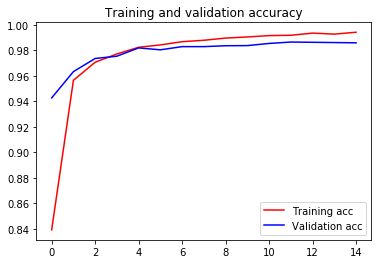

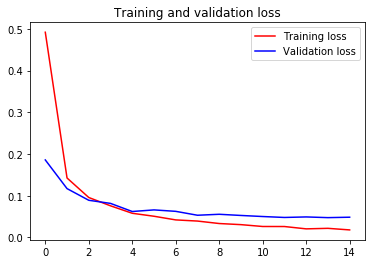

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

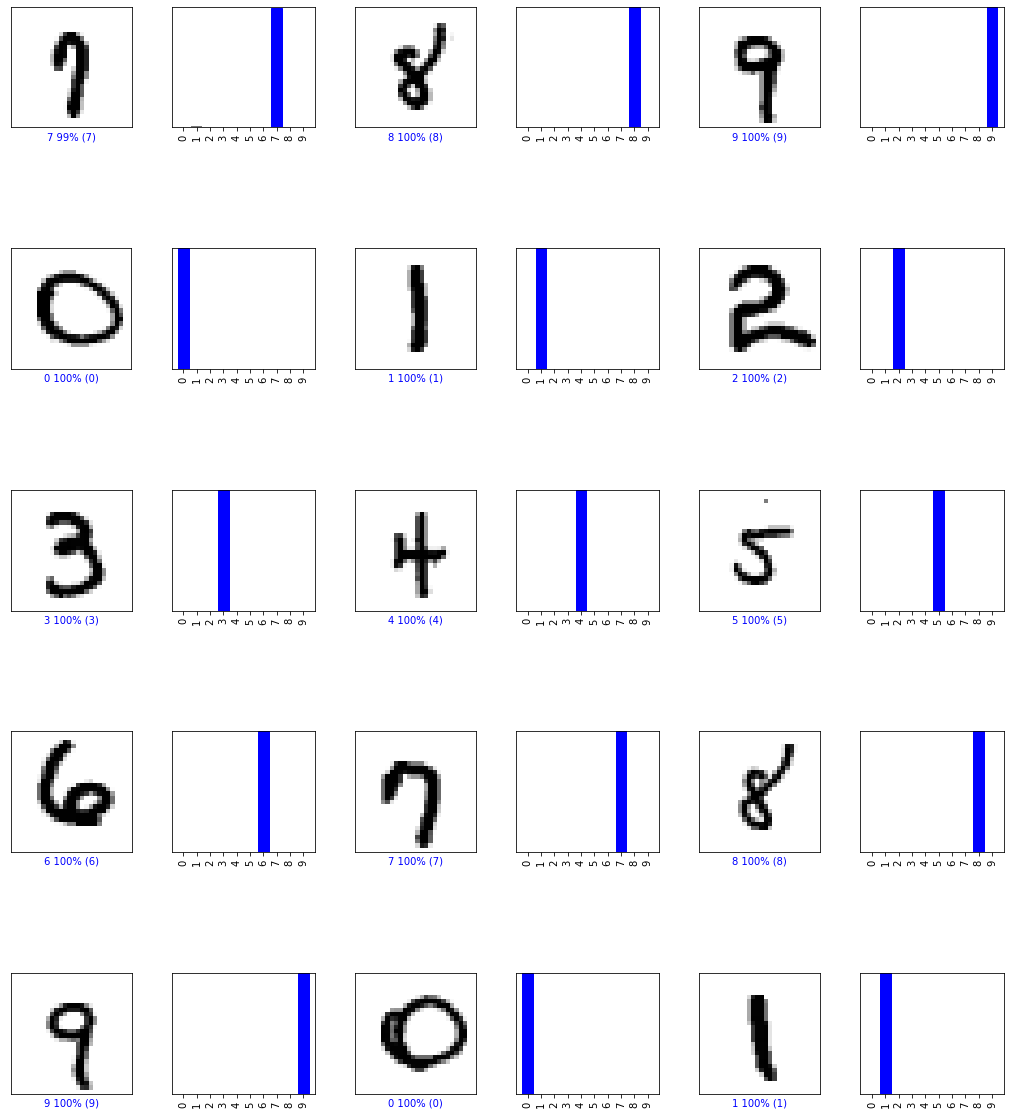

In [22]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model_k(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break